# WaMoS: Fitování 2f-WMS píků pomocí druhé derivace Pearson VII

Tento notebook rozšiřuje skript `wamos02.ipynb` o kvantitativní analýzu absorpčních linií:
- Detekce lokálních minim v normalizovaném 2f signálu
- Fitování každého piku pomocí druhé derivace Pearson VII
- Detekce zero-crossing bodů
- Integrace ploch pod křivkou
- Výpočet poměrů mezi sousedními píkami
- Vizualizace a tabulkový výstup


Použitá časová konstanta τ = 0.001 s → cutoff = 159.15 Hz
Lokální maxima:
1: t = 0.557, hodnota = 0.003
2: t = 0.690, hodnota = 0.002
3: t = 0.794, hodnota = 0.001
4: t = 0.949, hodnota = 0.001
5: t = 1.089, hodnota = 0.002
6: t = 1.280, hodnota = 0.001
7: t = 1.463, hodnota = 0.001
8: t = 1.798, hodnota = 0.001
9: t = 2.807, hodnota = 0.002
10: t = 2.914, hodnota = 0.029
11: t = 3.087, hodnota = 0.029
12: t = 3.232, hodnota = 0.011
13: t = 3.423, hodnota = 0.010
14: t = 4.314, hodnota = 0.002
15: t = 4.414, hodnota = 0.019
16: t = 4.600, hodnota = 0.023
17: t = 4.838, hodnota = 0.019
18: t = 4.945, hodnota = 0.002
19: t = 5.797, hodnota = 0.001
20: t = 5.912, hodnota = 0.013
21: t = 6.085, hodnota = 0.013
22: t = 6.186, hodnota = 0.001
23: t = 7.060, hodnota = 0.001
24: t = 7.161, hodnota = 0.013
25: t = 7.337, hodnota = 0.013
26: t = 7.438, hodnota = 0.001
27: t = 8.906, hodnota = 0.006
28: t = 9.087, hodnota = 0.006
Lokální minima:
1: t = 0.541, hodnota = -0.002
2: t = 0.649, hodnot

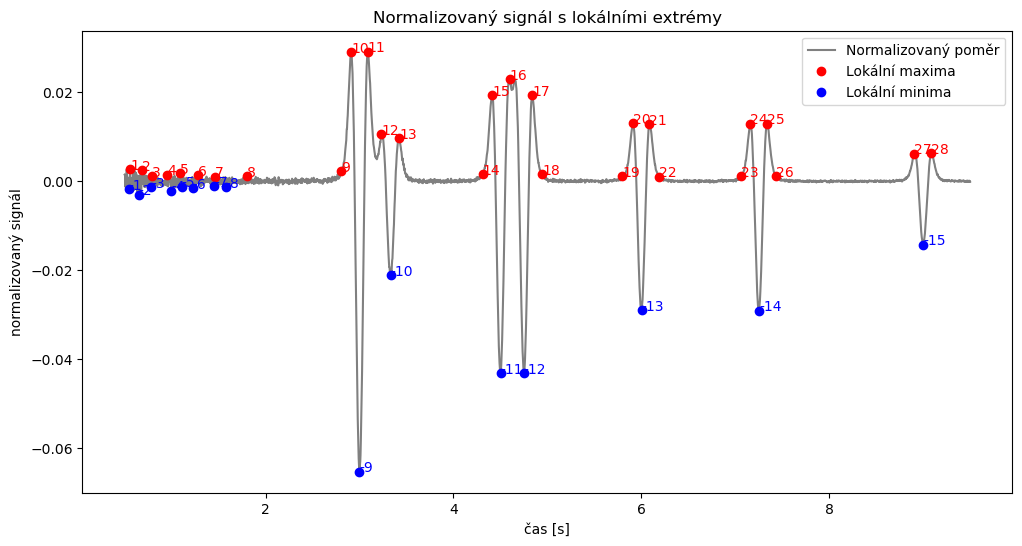

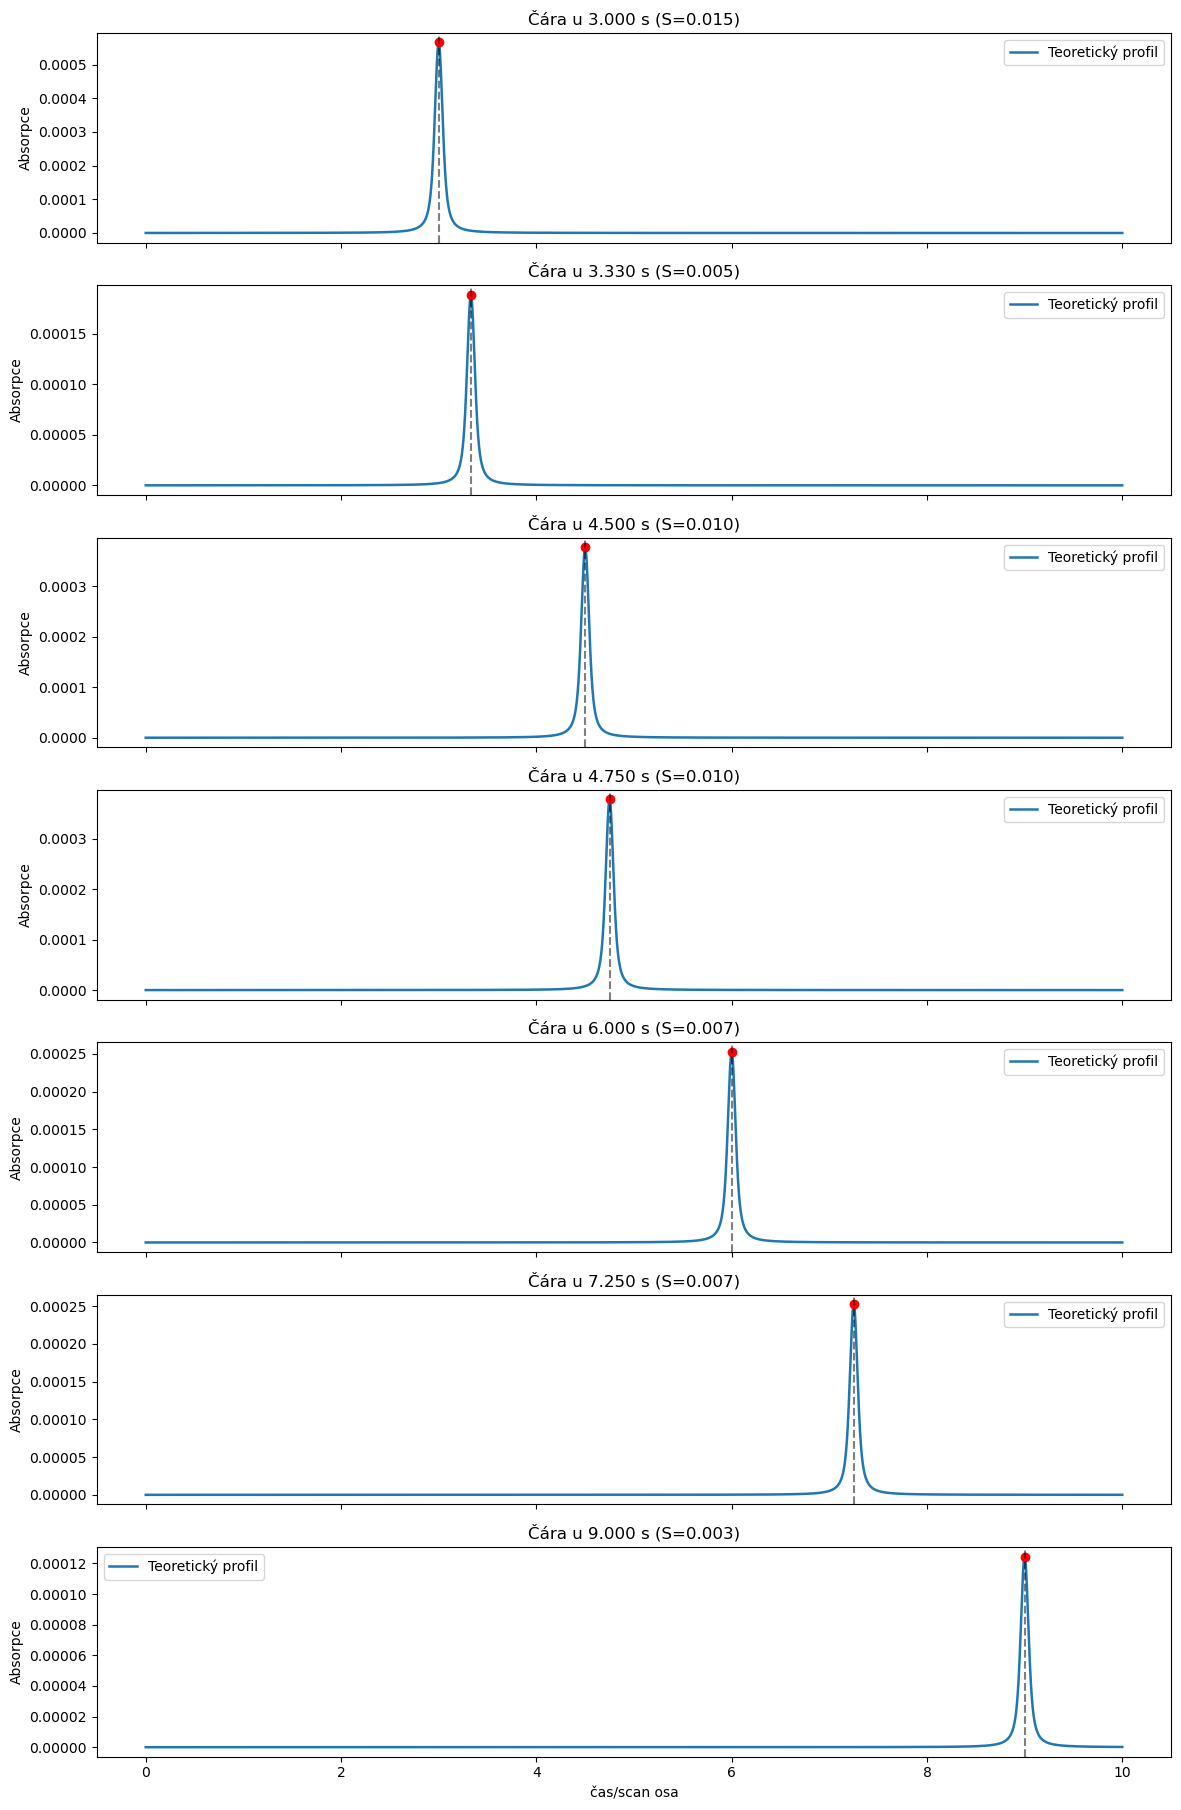

Relativní intenzity píků (hodnoty maxim):
Čára u 3.000s → maximum 0.00057
Čára u 3.330s → maximum 0.00019
Čára u 4.500s → maximum 0.00038
Čára u 4.750s → maximum 0.00038
Čára u 6.000s → maximum 0.00025
Čára u 7.250s → maximum 0.00025
Čára u 9.000s → maximum 0.00012
Srovnání amplitud a FWHM (s referencí k Voigtovu maximu):
Čára u 3.000s: A = 0.0056, Voigt_peak = 0.00057, A_exp/Voigt/FWHM_theory = 0.96, FWHM_exp = 0.132, FWHM_theory = 0.097, FWHM_ratio = 1.36
Čára u 3.000s: A = 0.0032, Voigt_peak = 0.00057, A_exp/Voigt/FWHM_theory = 0.55, FWHM_exp = 0.104, FWHM_theory = 0.097, FWHM_ratio = 1.07
Čára u 3.000s: A = 0.0038, Voigt_peak = 0.00057, A_exp/Voigt/FWHM_theory = 0.65, FWHM_exp = 0.140, FWHM_theory = 0.097, FWHM_ratio = 1.44
Čára u 3.000s: A = 0.0032, Voigt_peak = 0.00057, A_exp/Voigt/FWHM_theory = 0.55, FWHM_exp = 0.190, FWHM_theory = 0.097, FWHM_ratio = 1.96
Čára u 3.000s: A = 0.0022, Voigt_peak = 0.00057, A_exp/Voigt/FWHM_theory = 0.39, FWHM_exp = 0.184, FWHM_theory = 0.097, FWHM

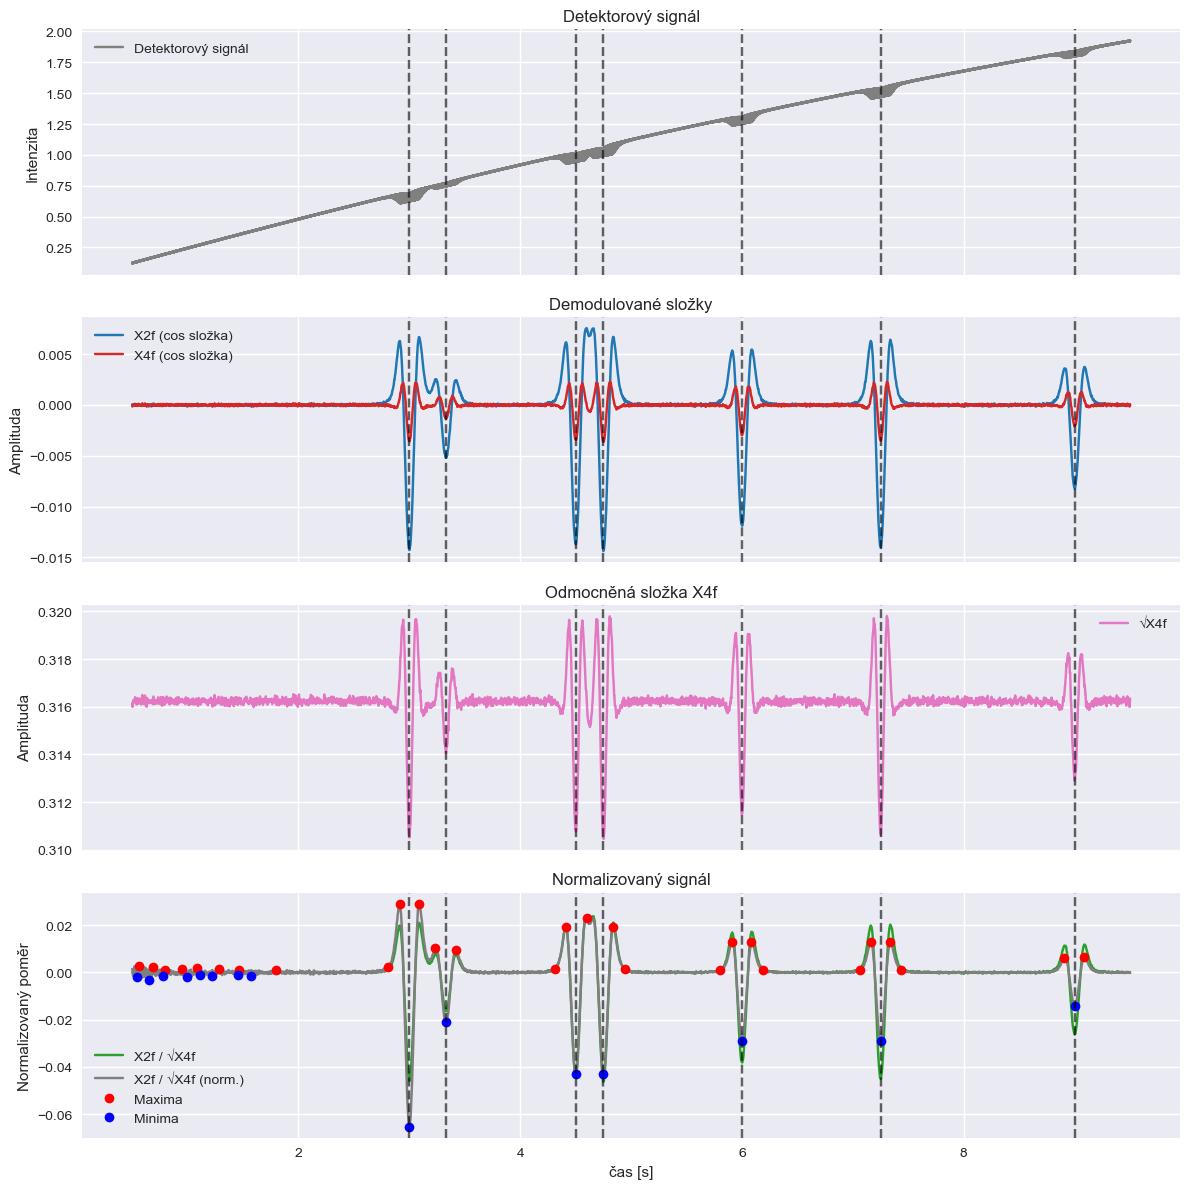

In [1]:
# ============================================
# Lock-in simulace s volitelným zadáním čar
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import wofz
from scipy.signal import butter, filtfilt, find_peaks
from scipy.optimize import curve_fit

from scipy.special import gamma as gamma_fn


# -----------------------------
# Parametry simulace
# -----------------------------
fs = 50000          # vzorkovací frekvence [Hz]
duration = 10.0     # délka [s]
t = np.linspace(0, duration, int(fs*duration))
n = len(t)

# -----------------------------
# Volba zdroje signálu
# -----------------------------
use_csv_signal = False   # True = načíst CSV, False = použít syntetický model
csv_file = "detector_signal.csv"

if use_csv_signal:
    # CSV musí mít sloupce: time, signal
    data = pd.read_csv(csv_file)
    t = data["time"].values
    signal_raw = data["signal"].values

    # Fit polynomem 4. stupně
    coeffs = np.polyfit(t, signal_raw, deg=4)
    poly_fit = np.polyval(coeffs, t)

    # Použijeme aproximovaný trend jako základní signál
    S_t = poly_fit

else:
    # Původní syntetická varianta
    S_t = 0.25 * t - 0.005 *t*t

# Modulační parametry
f_mod = 1234        # modulační frekvence [Hz]
mod_depth = 0.075
mod_signal = mod_depth * np.sin(2*np.pi*f_mod*t)
scan = t + mod_signal

# -----------------------------
# Definice čar
# -----------------------------
# Varianta 1: ruční zadání
# Každá položka: [pozice, intenzita, sigma, gamma]
lines_manual = [
    [3.0, 1.5e-2, 0.025, 0.03],
    [3.33, 0.5e-2, 0.025, 0.03],
    [4.5, 1.0e-2, 0.025, 0.03],
    [4.75, 1.0e-2, 0.025, 0.03],
    [6.0, 0.67e-2, 0.025, 0.03],
    [7.25, 0.67e-2, 0.025, 0.03],
    [9.0, 0.33e-2, 0.025, 0.03]
]

# Varianta 2: načtení z HITRAN-like CSV
# CSV musí mít sloupce: position, intensity, sigma, gamma
use_hitran = False   # <- přepínač: True = použít CSV, False = ruční zadání
hitran_file = "hitran_lines.csv"

if use_hitran:
    hitran_data = pd.read_csv(hitran_file)
    lines = hitran_data[["position", "intensity", "sigma", "gamma"]].values.tolist()
else:
    lines = lines_manual

# -----------------------------
# Voigtův profil a absorpce
# -----------------------------
def voigt(x, sigma, gamma):
    z = (x + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

def absorption_profile(scan, lines):
    absorption = np.zeros_like(scan)
    for xc, strength, sigma, gamma in lines:
        absorption += strength * voigt(scan - xc, sigma, gamma)
    return absorption

absorption = absorption_profile(scan, lines)

# -----------------------------
# Detektorový signál se šumem
# -----------------------------
noise_std = 0.001
signal = S_t * (1 - absorption) + np.random.normal(0, noise_std, n)

# -----------------------------
# Adaptace časové konstanty τ
# -----------------------------
tau = 0.001  # časová konstanta lock-inu [s]
f_cut = 1/(2*np.pi*tau)   # mezní frekvence -3 dB
print(f"Použitá časová konstanta τ = {tau:.3f} s → cutoff = {f_cut:.2f} Hz")

def lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# -----------------------------
# Lock-in demodulace
# -----------------------------
# 2f
fref2f = 2*f_mod
refcos2f = np.cos(2*np.pi*fref2f*t)
refsin2f = np.sin(2*np.pi*fref2f*t)
xraw2f = signal * refcos2f
yraw2f = signal * refsin2f
xfiltered = lowpass_filter(xraw2f, f_cut, fs)
yfiltered2f = lowpass_filter(yraw2f, f_cut, fs)

# 4f
fref4f = 4*f_mod
refcos4f = np.cos(2*np.pi*fref4f*t)
refsin4f = np.sin(2*np.pi*fref4f*t)
xraw4f = signal * refcos4f
yraw4f = signal * refsin4f
xfiltered4f = lowpass_filter(xraw4f, f_cut, fs)
yfiltered4f = lowpass_filter(yraw4f, f_cut, fs)

# -----------------------------
# Normalizace a poměry
# -----------------------------
def safe_divide(num, denom, eps=1e-12):
    return num / (denom + eps)
k=0.1
ratio = safe_divide(xfiltered, np.sqrt(xfiltered4f + k))
ratio_normalized = safe_divide(ratio, S_t)

# -----------------------------
# Hodnoticí kritéria
# -----------------------------
mask = (t >= 0.5) & (t <= 9.5)
t_sel = t[mask]
ratio_seln = ratio_normalized[mask]

# Nastav prahovou hodnotu (např. 0.002 = jen výrazné píky)
threshold = 0.001

min_time = 0.1  # sekundy
distance_int = int(min_time * fs)  # převedeno na vzorky

# Najdi lokální maxima nad prahem
peaks_max, props_max = find_peaks(ratio_seln, distance=distance_int, height=threshold)
peak_vals_max = ratio_seln[peaks_max]

# Najdi lokální minima pod -prahem (tj. dost hluboké záporné hodnoty)
peaks_min, props_min = find_peaks(-ratio_seln, distance=5000, height=threshold)
peak_vals_min = ratio_seln[peaks_min]

# Výpis hodnot
print("Lokální maxima:")
for i, idx in enumerate(peaks_max, 1):
    print(f"{i}: t = {t_sel[idx]:.3f}, hodnota = {ratio_seln[idx]:.3f}")

print("Lokální minima:")
for i, idx in enumerate(peaks_min, 1):
    print(f"{i}: t = {t_sel[idx]:.3f}, hodnota = {ratio_seln[idx]:.3f}")

# Vizualizace
plt.figure(figsize=(12,6))
plt.plot(t_sel, ratio_seln, color='grey', label='Normalizovaný poměr')

# maxima červeně
plt.plot(t_sel[peaks_max], ratio_seln[peaks_max], 'ro', label='Lokální maxima')
for i, idx in enumerate(peaks_max, 1):
    plt.text(t_sel[idx], ratio_seln[idx], f'{i}', color='red', fontsize=10)

# minima modře
plt.plot(t_sel[peaks_min], ratio_seln[peaks_min], 'bo', label='Lokální minima')
for i, idx in enumerate(peaks_min, 1):
    plt.text(t_sel[idx], ratio_seln[idx], f'-{i}', color='blue', fontsize=10)

plt.xlabel("čas [s]")
plt.ylabel("normalizovaný signál")
plt.title("Normalizovaný signál s lokálními extrémy")
plt.legend()
plt.show()

# ============================================
# Teoretické profily absorpčních linií (konstantní délka kyvety)
# ============================================

scan_theory = t  # monotónní osa (bez modulace)

cell_length = 1.0   # konstantní délka kyvety
scale = 0.005       # škálovací faktor absorpce

def single_line_absorption(scan_axis, xc, strength, sigma, gamma, cell_length=1.0, scale=0.005):
    return (strength * cell_length) * voigt(scan_axis - xc, sigma, gamma) * scale

fig, ax = plt.subplots(len(lines), 1, figsize=(12, 2.6*len(lines)), sharex=True)
peak_summary = []

for i, (xc, strength, sigma, gamma) in enumerate(lines):
    prof = single_line_absorption(scan_theory, xc, strength, sigma, gamma,
                                  cell_length=cell_length, scale=scale)
    ax[i].plot(scan_theory, prof, color='tab:blue', lw=1.8, label='Teoretický profil')

    # Najdi maximum profilu v okolí xc
    win = 0.8
    m = (scan_theory >= xc - win/2) & (scan_theory <= xc + win/2)
    prof_win = prof[m]
    scan_win = scan_theory[m]

    if prof_win.size > 0:
        idx_peak = np.argmax(prof_win)
        peak_pos = scan_win[idx_peak]
        peak_val = prof_win[idx_peak]
        ax[i].plot(peak_pos, peak_val, 'ro')
        peak_summary.append({
            "line_center": xc,
            "peak_pos": peak_pos,
            "peak_value": peak_val
        })

    ax[i].axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylabel("Absorpce")
    ax[i].set_title(f"Čára u {xc:.3f} s (S={strength:.3f})")
    ax[i].legend()

ax[-1].set_xlabel("čas/scan osa")
plt.tight_layout()
plt.show()

# Výpis relativních intenzit (hodnot maxim)
print("Relativní intenzity píků (hodnoty maxim):")
for rec in peak_summary:
    print(f"Čára u {rec['line_center']:.3f}s → maximum {rec['peak_value']:.5f}")


# --- Výpočet amplitud experimentalnich čar (2 maxima + 1 minimum) ---
amplitudes = []

# Seřadíme indexy podle času
all_max = sorted(peaks_max)
all_min = sorted(peaks_min)

for i in range(len(all_max)-1):
    left_max = all_max[i]
    right_max = all_max[i+1]

    # Najdi minima mezi těmito dvěma maximy
    local_minima = [m for m in all_min if left_max < m < right_max]
    if len(local_minima) == 0:
        continue  # žádné minimum mezi max → přeskoč

    # Vezmeme nejhlubší minimum mezi max
    min_idx = local_minima[np.argmin(ratio_seln[local_minima])]

    # Hodnoty
    val_left = ratio_seln[left_max]
    val_right = ratio_seln[right_max]
    val_min = ratio_seln[min_idx]

    # Amplituda = průměr obou maxim - minimum
    amplitude = ( (val_left + val_right)/2 ) - val_min

    amplitudes.append({
        "t_left_max": t_sel[left_max],
        "t_right_max": t_sel[right_max],
        "t_min": t_sel[min_idx],
        "amplitude": amplitude
    })


# Funkce: maximum Voigtova profilu pro danou čáru
def voigt_peak_value(xc, sigma, gamma, strength=1.0, scale=0.005):
    # Vypočítáme profil v okolí xc
    x_local = np.linspace(xc - 0.5, xc + 0.5, 2000)
    profile = strength * voigt(x_local - xc, sigma, gamma) * scale
    return np.max(profile)

# -----------------------------
# Výpis výsledků – amplitudy vs. Voigtovy pík hodnoty
# -----------------------------
results = []

print("Srovnání amplitud a FWHM (s referencí k Voigtovu maximu):")
for amp in amplitudes:
    t_min = amp["t_min"]
    nearest_line = min(lines, key=lambda l: abs(l[0] - t_min))
    line_pos, line_strength, sigma, gamma = nearest_line

    # Referenční hodnota = maximum Voigtova profilu
    voigt_peak = voigt_peak_value(line_pos, sigma, gamma, strength=line_strength)
    # Experimentální a teoretická FWHM
    fwhm_exp = amp["t_right_max"] - amp["t_left_max"]
    fwhm_theory = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)
    fwhm_ratio = fwhm_exp / fwhm_theory

    # Poměr amplitudy k Voigtovu maximu
    amp_ratio = (amp["amplitude"]) / (voigt_peak/fwhm_theory)


    results.append({
        "line_pos": line_pos,
        "voigt_peak": voigt_peak,
        "amplitude": amp["amplitude"],
        "amp_ratio": amp_ratio,
        "fwhm_exp": fwhm_exp,
        "fwhm_theory": fwhm_theory,
        "fwhm_ratio": fwhm_ratio
    })

    print(f"Čára u {line_pos:.3f}s: "
          f"A = {amp['amplitude']:.4f}, "
          f"Voigt_peak = {voigt_peak:.5f}, "
          f"A_exp/Voigt/FWHM_theory = {amp_ratio:.2f}, "
          f"FWHM_exp = {fwhm_exp:.3f}, "
          f"FWHM_theory = {fwhm_theory:.3f}, "
          f"FWHM_ratio = {fwhm_ratio:.2f}")



# Výpis výsledků
print("Amplitudy čar (2 maxima + 1 minimum):")
for i, amp in enumerate(amplitudes, 1):
    print(f"{i}: mezi {amp['t_left_max']:.3f}s a {amp['t_right_max']:.3f}s "
          f"(min v {amp['t_min']:.3f}s) → A = {amp['amplitude']:.4f}")

results = []

for amp in amplitudes:
    # Najdi nejbližší čáru podle pozice minima
    t_min = amp["t_min"]
    nearest_line = min(lines, key=lambda l: abs(l[0] - t_min))
    line_pos, line_intensity, sigma, gamma = nearest_line

    # Poměr amplitudy k intenzitě
    amp_ratio = amp["amplitude"] / line_intensity

    # Experimentální FWHM = vzdálenost mezi dvěma maximy
    fwhm_exp = amp["t_right_max"] - amp["t_left_max"]

    # Teoretická FWHM (aproximace Voigtova profilu)
    fwhm_theory = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)

    fwhm_ratio = fwhm_exp / fwhm_theory

    results.append({
        "line_pos": line_pos,
        "intensity": line_intensity,
        "amplitude": amp["amplitude"],
        "amp_ratio": amp_ratio,
        "fwhm_exp": fwhm_exp,
        "fwhm_theory": fwhm_theory,
        "fwhm_ratio": fwhm_ratio
    })

# Výpis výsledků
print("Srovnání amplitud a FWHM:")
for r in results:
    print(f"Čára u {r['line_pos']:.3f}s: "
          f"A = {r['amplitude']:.4f}, I = {r['intensity']:.4f}, A/I = {r['amp_ratio']:.4f}, "
          f"FWHM_exp = {r['fwhm_exp']:.3f}, FWHM_theory = {r['fwhm_theory']:.3f}, "
          f"FWHM_ratio = {r['fwhm_ratio']:.2f}")

# -----------------------------
# Výpočet baseline masky dynamicky podle čar
# -----------------------------
exclude_halfwidth = 0.5  # [s] – poloviční šířka oblasti, kterou vynecháme kolem každé čáry

# Začneme s maskou, kde je vše True
baseline_mask = np.ones_like(t_sel, dtype=bool)

for xc, strength, sigma, gamma in lines:
    # Vynecháme interval [xc - Δ, xc + Δ]
    baseline_mask &= ~((t_sel >= (xc - exclude_halfwidth)) & (t_sel <= (xc + exclude_halfwidth)))

# Výpočet směrodatné odchylky baseline
baseline_std = np.std(ratio_seln[baseline_mask])

print("Baseline std:", baseline_std)


# -----------------------------
# Vizualizace
# -----------------------------

# --- Výběr intervalu 0.5–9.5 s ---
mask = (t >= 0.5) & (t <= 9.5)
t_sel = t[mask]
signal_sel = signal[mask]
x2f_sel = xfiltered[mask]
x4f_sel = xfiltered4f[mask]
x4f_sqrt_sel = np.sqrt(xfiltered4f[mask] + 0.1)
ratio_sel = ratio[mask]
ratio_seln = ratio_normalized[mask]

# --- Vizualizace ---
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 1. Detektorový signál
axs[0].plot(t_sel, signal_sel, color='gray', label='Detektorový signál')
axs[0].set_ylabel("Intenzita")
axs[0].set_title("Detektorový signál")
axs[0].legend()

# 2. Demodulované složky
axs[1].plot(t_sel, x2f_sel, label='X2f (cos složka)', color='tab:blue')
axs[1].plot(t_sel, x4f_sel, label='X4f (cos složka)', color='tab:red')
axs[1].set_ylabel("Amplituda")
axs[1].set_title("Demodulované složky")
axs[1].legend()

# 3. Odmocněná složka X4f
axs[2].plot(t_sel, x4f_sqrt_sel, label='√X4f', color='tab:pink')
axs[2].set_ylabel("Amplituda")
axs[2].set_title("Odmocněná složka X4f")
axs[2].legend()

# 4. Poměry a normalizace
axs[3].plot(t_sel, ratio_sel, label='X2f / √X4f', color='tab:green')
axs[3].plot(t_sel, ratio_seln, label='X2f / √X4f (norm.)', color='tab:grey')

# Pokud máš vypočtené maxima/minima, vykresli je
if 'peaks_max' in locals():
    axs[3].plot(t_sel[peaks_max], ratio_seln[peaks_max], 'ro', label='Maxima')
if 'peaks_min' in locals():
    axs[3].plot(t_sel[peaks_min], ratio_seln[peaks_min], 'bo', label='Minima')

axs[3].set_xlabel("čas [s]")
axs[3].set_ylabel("Normalizovaný poměr")
axs[3].set_title("Normalizovaný signál")
axs[3].legend()

# Svislé čáry pro čárové pozice
for ax in axs:
    for xc, strength, sigma, gamma in lines:
        if 0.5 <= xc <= 9.5:
            ax.axvline(x=xc, color='black', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [2]:
# Vytvoř DataFrame s časem a X2f složkou
df_export_X2f4fn = pd.DataFrame({
    "time_s": t_sel,
#    "X2f_signal": -x2f_sel
    "X2f / √X4f (norm.)": -ratio_seln
})

# Ulož do CSV souboru
df_export_X2f4fn.to_csv("export_X2f4fn_signal.csv", index=False)

print("✅ Export dokončen: export_X24f(norm)_signal.csv obsahuje čas a X2f signál normalizovany X4f a detektorovym pozadim.")


✅ Export dokončen: export_X24f(norm)_signal.csv obsahuje čas a X2f signál normalizovany X4f a detektorovym pozadim.


Detekováno 20 maxim, po filtru zůstává 6.


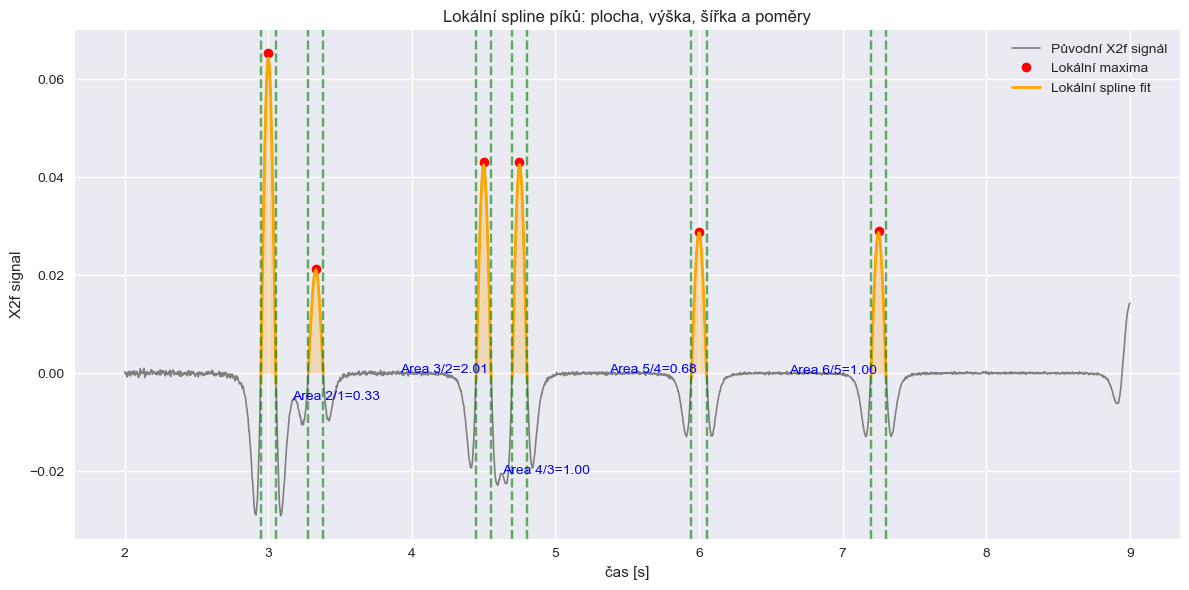

Parametry píků (experimentální vs teoretické):


,center_idx,x0,y0,xL,xR,area,height,width,x0_theory,amp_theory,width_theory
0,49985,2.999706,0.065291,2.946902,3.052896,0.004206,0.064382,0.068329,3.00,0.0150,0.025
1,66622,3.332447,0.021176,3.278343,3.382694,0.001370,0.021121,0.067583,3.33,0.0050,0.025
2,125041,4.500829,0.043197,4.447195,4.551902,0.002757,0.042515,0.067918,4.50,0.0100,0.025
3,137448,4.748969,0.043127,4.698100,4.802894,0.002761,0.042643,0.067764,4.75,0.0100,0.025
4,200098,6.001972,0.028918,5.946767,6.053316,0.001880,0.028706,0.068366,6.00,0.0067,0.025
5,262566,7.251335,0.029099,7.196974,7.302954,0.001885,0.028774,0.068425,7.25,0.0067,0.025


Poměry sousedních píků (experimentální plocha, výška vs teorie):


,pair,ratio_area,ratio_height,ratio_amp_theory
0,"(0, 1)",0.325803,0.328062,0.333333
1,"(1, 2)",2.011850,2.012893,2.000000
2,"(2, 3)",1.001389,1.003024,1.000000
3,"(3, 4)",0.680866,0.673157,0.670000
4,"(4, 5)",1.002464,1.002365,1.000000


In [3]:
# ============================================
# WaMoS: Analýza 2f-WMS signálu s lokálním spline + výšky a šířky
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy.signal import find_peaks

# -----------------------------
# 1. Načtení CSV souboru
# -----------------------------
df_import = pd.read_csv("export_X2f4fn_signal.csv")
t_loaded = df_import["time_s"].values
x2f_loaded = df_import["X2f / √X4f (norm.)"].values

# -----------------------------
# 2. Volba integračního intervalu
# -----------------------------
t_min, t_max = 2.0, 9.0
mask = (t_loaded >= t_min) & (t_loaded <= t_max)
t_win = t_loaded[mask]
x_win = x2f_loaded[mask]

# -----------------------------
# 3. Teoretické linie
# -----------------------------
lines_manual = [
    [3.0, 1.5e-2, 0.025, 0.03],
    [3.33, 0.5e-2, 0.025, 0.03],
    [4.5, 1.0e-2, 0.025, 0.03],
    [4.75, 1.0e-2, 0.025, 0.03],
    [6.0, 0.67e-2, 0.025, 0.03],
    [7.25, 0.67e-2, 0.025, 0.03],
    [9.0, 0.33e-2, 0.025, 0.03]
]
df_theory = pd.DataFrame(lines_manual, columns=["x0_theory","amp_theory","width_theory","gamma_theory"])

# -----------------------------
# 4. Pomocné funkce
# -----------------------------
def detect_maxima(x, y, distance=30, prominence=0.001):
    idx, _ = find_peaks(y, distance=distance, prominence=prominence)
    return idx

def zero_crossings_bounds(x, y, center_idx):
    left = center_idx
    while left > 1 and np.sign(y[left]) == np.sign(y[left-1]):
        left -= 1
    right = center_idx
    while right < len(y)-2 and np.sign(y[right]) == np.sign(y[right+1]):
        right += 1
    def interp_zero(xp, yp):
        if len(xp)==2 and yp[1]!=yp[0]:
            return xp[0] - yp[0]*(xp[1]-xp[0])/(yp[1]-yp[0])
        return xp[0]
    xzc_l = interp_zero(x[left-1:left+1], y[left-1:left+1])
    xzc_r = interp_zero(x[right:right+2], y[right:right+2])
    return xzc_l, xzc_r

def fwhm_width(xg, yg):
    """Najde FWHM (šířku v polovině maxima)."""
    y_max = np.max(yg)
    half = y_max/2.0
    above = yg >= half
    if not np.any(above):
        return np.nan
    idx = np.where(above)[0]
    return xg[idx[-1]] - xg[idx[0]]

def quantify_peaks_local_spline(x, y, maxima_idx):
    results = []
    for idx in maxima_idx:
        x0 = x[idx]
        y0 = y[idx]
        xL, xR = zero_crossings_bounds(x, y, idx)
        mask = (x >= xL) & (x <= xR)
        x_local = x[mask]
        y_local = y[mask]
        s_local = 0.001 * np.sum((y_local - np.median(y_local))**2)
        spline_local = UnivariateSpline(x_local, y_local, s=s_local)
        xg = np.linspace(xL, xR, 1000)
        yg = spline_local(xg)
        area = simpson(yg, x=xg)
        width = fwhm_width(xg, yg)
        height = np.max(yg)
        results.append({
            "center_idx": idx,
            "x0": x0,
            "y0": y0,
            "xL": xL,
            "xR": xR,
            "area": area,
            "height": height,
            "width": width,
            "xg": xg,
            "yg": yg
        })
    ratios = []
    for i in range(len(results)-1):
        ratios.append({
            "pair": (i, i+1),
            "ratio_area": results[i+1]["area"]/results[i]["area"],
            "ratio_height": results[i+1]["height"]/results[i]["height"]
        })
    return results, ratios

# -----------------------------
# 5. Detekce maxim a filtr
# -----------------------------
maxima_idx = detect_maxima(t_win, x_win, distance=30, prominence=0.001)
threshold = 0.05 * np.max(x_win)
maxima_idx_filtered = [i for i in maxima_idx if x_win[i] >= threshold]

print(f"Detekováno {len(maxima_idx)} maxim, po filtru zůstává {len(maxima_idx_filtered)}.")

# -----------------------------
# 6. Kvantifikace
# -----------------------------
results, ratios = quantify_peaks_local_spline(t_win, x_win, maxima_idx_filtered)

# -----------------------------
# 7. Vizualizace
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(t_win, x_win, color='gray', lw=1.2, label='Původní X2f signál')
plt.plot(t_win[maxima_idx_filtered], x_win[maxima_idx_filtered], 'o', color='red', label='Lokální maxima')

for i, r in enumerate(results):
    plt.plot(r["xg"], r["yg"], color='orange', linewidth=2,
             label='Lokální spline fit' if i==0 else None)
    plt.axvline(r["xL"], color='green', linestyle='--', alpha=0.6)
    plt.axvline(r["xR"], color='green', linestyle='--', alpha=0.6)
    plt.fill_between(r["xg"], r["yg"], 0,
                     where=(r["xg"]>=r["xL"]) & (r["xg"]<=r["xR"]),
                     color='orange', alpha=0.25)

for rr in ratios:
    i, j = rr["pair"]
    xm = 0.5*(results[i]["x0"] + results[j]["x0"])
    ym = np.interp(xm, t_win, x_win)
#    plt.text(xm, ym, f'Area {j+1}/{i+1}={rr["ratio_area"]:.2f}\nHeight {j+1}/{i+1}={rr["ratio_height"]:.2f}', color='blue')
    plt.text(xm, ym, f'Area {j+1}/{i+1}={rr["ratio_area"]:.2f}', color='blue')

plt.xlabel('čas [s]')
plt.ylabel('X2f signal')
plt.title('Lokální spline píků: plocha, výška, šířka a poměry')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Tabulkový výstup
# -----------------------------
df_peaks = pd.DataFrame([{k: v for k, v in r.items() if k not in ("xg","yg")} for r in results])
df_ratios = pd.DataFrame(ratios)

# Sloučení s teoretickými hodnotami podle nejbližšího x0
df_peaks["x0_theory"] = np.nan
df_peaks["amp_theory"] = np.nan
df_peaks["width_theory"] = np.nan
for i, row in df_peaks.iterrows():
    diffs = np.abs(df_theory["x0_theory"] - row["x0"])
    j = diffs.idxmin()
    df_peaks.loc[i,"x0_theory"] = df_theory.loc[j,"x0_theory"]
    df_peaks.loc[i,"amp_theory"] = df_theory.loc[j,"amp_theory"]
    df_peaks.loc[i,"width_theory"] = df_theory.loc[j,"width_theory"]

print("Parametry píků (experimentální vs teoretické):")
display(df_peaks)

# -----------------------------
# Poměry sousedních píků
# -----------------------------
df_ratios = pd.DataFrame(ratios)

# Doplnění teoretických poměrů amplitud
theory_ratios = []
for i in range(len(df_theory)-1):
    r_amp = df_theory.loc[i+1,"amp_theory"] / df_theory.loc[i,"amp_theory"]
    theory_ratios.append({"pair": (i,i+1), "ratio_amp_theory": r_amp})
df_theory_ratios = pd.DataFrame(theory_ratios)

# Sloučení experimentálních a teoretických poměrů
df_ratios_full = df_ratios.merge(df_theory_ratios, on="pair", how="left")

print("Poměry sousedních píků (experimentální plocha, výška vs teorie):")
display(df_ratios_full)


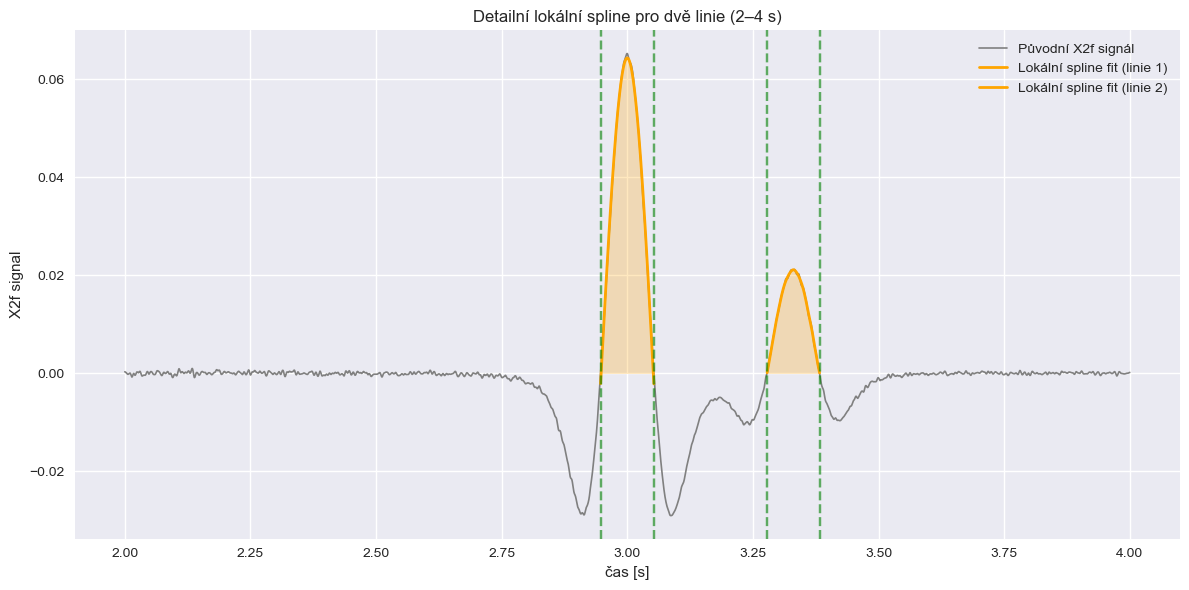

Detailní parametry dvou vybraných linií (experiment vs teorie):


,center_idx,x0,y0,xL,xR,area,height,width,x0_theory,amp_theory,width_theory
0,49985,2.999706,0.065291,2.946902,3.052896,0.004206,0.064382,0.068329,3.00,0.015,0.025
1,66622,3.332447,0.021176,3.278343,3.382694,0.001370,0.021121,0.067583,3.33,0.005,0.025


Poměry mezi dvěma vybranými liniemi (2–4 s):


,linie_pair,ratio_area_exp,ratio_height_exp,ratio_amp_theory
0,1-2,0.325803,0.328062,0.333333


In [4]:
# ============================================
# Detailní analýza pro dvě vybrané linie v intervalu 2–4 s
# ============================================

# Nastav detailní časové okno
t_min_detail, t_max_detail = 2.0, 4.0

# Vyber indexy dvou linií z df_peaks (např. první dvě v tomto intervalu)
candidates = df_peaks[(df_peaks["x0"] >= t_min_detail) & (df_peaks["x0"] <= t_max_detail)].index.tolist()
if len(candidates) >= 2:
    idx1, idx2 = candidates[0], candidates[1]
else:
    idx1, idx2 = 0, 1  # fallback

line1 = results[idx1]
line2 = results[idx2]

# Vykreslení detailního grafu jen v intervalu 2–4 s
plt.figure(figsize=(12, 6))
mask_detail = (t_win >= t_min_detail) & (t_win <= t_max_detail)
plt.plot(t_win[mask_detail], x_win[mask_detail], color='gray', lw=1.2, label='Původní X2f signál')

for i, r in enumerate([line1, line2]):
    mask_local = (r["xg"] >= t_min_detail) & (r["xg"] <= t_max_detail)
    plt.plot(r["xg"][mask_local], r["yg"][mask_local], color='orange', linewidth=2,
             label=f'Lokální spline fit (linie {i+1})')
    plt.axvline(r["xL"], color='green', linestyle='--', alpha=0.6)
    plt.axvline(r["xR"], color='green', linestyle='--', alpha=0.6)
    plt.fill_between(r["xg"][mask_local], r["yg"][mask_local], 0,
                     where=(r["xg"][mask_local]>=r["xL"]) & (r["xg"][mask_local]<=r["xR"]),
                     color='orange', alpha=0.25)

plt.xlabel('čas [s]')
plt.ylabel('X2f signal')
plt.title('Detailní lokální spline pro dvě linie (2–4 s)')
plt.legend()
plt.tight_layout()
plt.show()

# Tabulka parametrů obou linií
df_detail = pd.DataFrame([
    {k: v for k, v in line1.items() if k not in ("xg","yg")},
    {k: v for k, v in line2.items() if k not in ("xg","yg")}
])

# Doplnění teorie
for i, row in df_detail.iterrows():
    diffs = np.abs(df_theory["x0_theory"] - row["x0"])
    j = diffs.idxmin()
    df_detail.loc[i,"x0_theory"] = df_theory.loc[j,"x0_theory"]
    df_detail.loc[i,"amp_theory"] = df_theory.loc[j,"amp_theory"]
    df_detail.loc[i,"width_theory"] = df_theory.loc[j,"width_theory"]

print("Detailní parametry dvou vybraných linií (experiment vs teorie):")
display(df_detail)

# Poměry mezi dvěma liniemi
ratio_area = line2["area"] / line1["area"]
ratio_height = line2["height"] / line1["height"]

amp1 = df_detail.loc[0,"amp_theory"]
amp2 = df_detail.loc[1,"amp_theory"]
ratio_amp_theory = amp2 / amp1

df_detail_ratios = pd.DataFrame([{
    "linie_pair": f"{idx1+1}-{idx2+1}",
    "ratio_area_exp": ratio_area,
    "ratio_height_exp": ratio_height,
    "ratio_amp_theory": ratio_amp_theory
}])

print("Poměry mezi dvěma vybranými liniemi (2–4 s):")
display(df_detail_ratios)
